In [1]:
from datasets import load_dataset, DatasetDict, concatenate_datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import warnings
from transformers import WhisperProcessor, WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline
from huggingface_hub import HfApi, HfFolder, Repository
import torch
from dataclasses import dataclass
import evaluate
from typing import Any, Dict, List, Union
from IPython.display import Audio, display

warnings.filterwarnings('ignore')

# Load Dataset

In [ ]:
lang_used=['zh-CN', 'ru-RU', 'fr-FR', 'en-US', 'de-DE']
minds=[]
for i in lang_used:
    minds_data = load_dataset("PolyAI/minds14", i, trust_remote_code=True)
    minds.append(minds_data['train'])

minds = concatenate_datasets(minds)
minds

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 2754
})

In [ ]:
minds = minds.train_test_split(test_size=0.4, seed = 21, stratify_by_column="intent_class")
minds_test = minds['test'].train_test_split(test_size=0.5, seed=21, stratify_by_column="intent_class")
dataset = DatasetDict({
    'train': minds['train'],
    'test': minds_test['test'],
    'valid': minds_test['train']})
# see structure
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 1652
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 551
    })
    valid: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 551
    })
})

# MODELLING FOR AUDIO RECOGNITION


## WHISPER TINY

DATA PREPROCESSING

In [ ]:
def noise(data):
    noise_amp = 0.00001*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps=3, bins_per_octave=24):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps, bins_per_octave=bins_per_octave)

In [ ]:
# taking any example and checking for techniques.
path = np.array(minds['train']['path'])[1]
data, sample_rate = librosa.load(path)

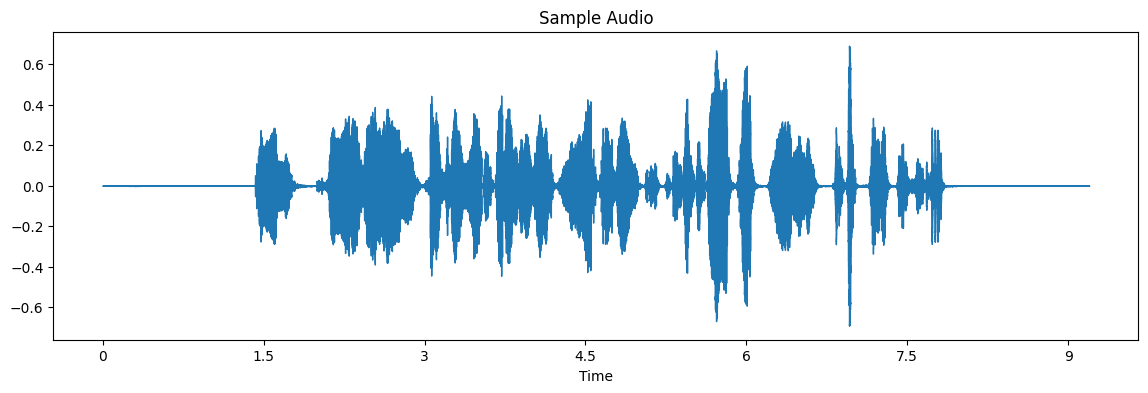

In [ ]:
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=data, sr=sample_rate)
display(Audio(path))

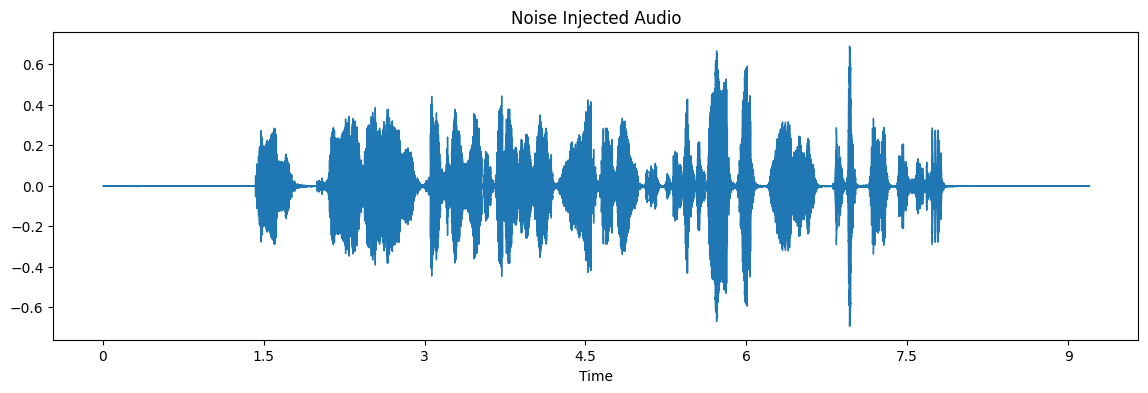

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.title('Noise Injected Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.title('Stretched Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

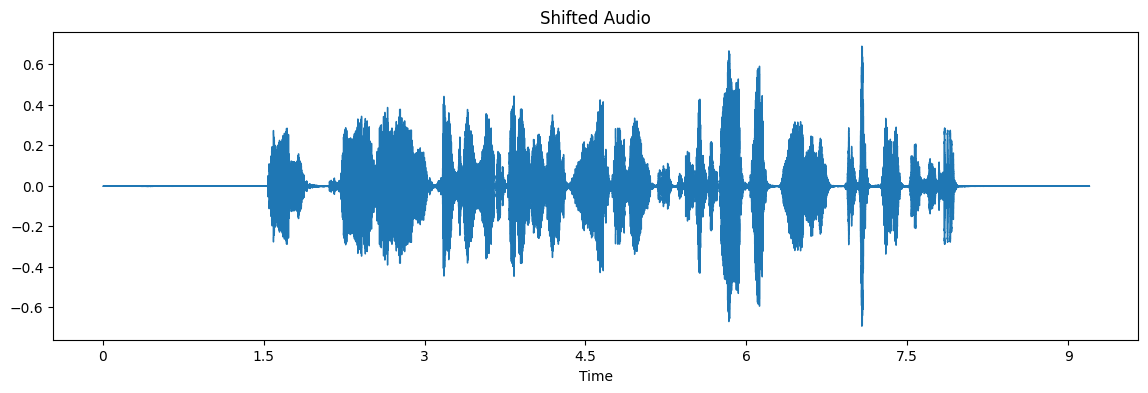

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.title('Shifted Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
plt.title('Pitched Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
dataset_run = dataset.remove_columns(["english_transcription", "intent_class", "lang_id"])

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny", language="english", task="transcribe")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [ ]:
# To simplify using the feature extractor and tokenizer, we can wrap both into a single WhisperProcessor class
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny", language="english", task="transcribe")

input_str = dataset["train"][1]["transcription"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 hi I am traveling in Italy right now and I'm just trying to figure out if my
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>hi I am traveling in Italy right now and I'm just trying to figure out if my<|endoftext|>
Decoded w/out special: hi I am traveling in Italy right now and I'm just trying to figure out if my
Are equal:             True


In [ ]:
# taking any example and checking for techniques.
path = dataset_run['train']['audio'][1]['path']
data, sample_rate = librosa.load(path)

In [ ]:
sample_rate

22050

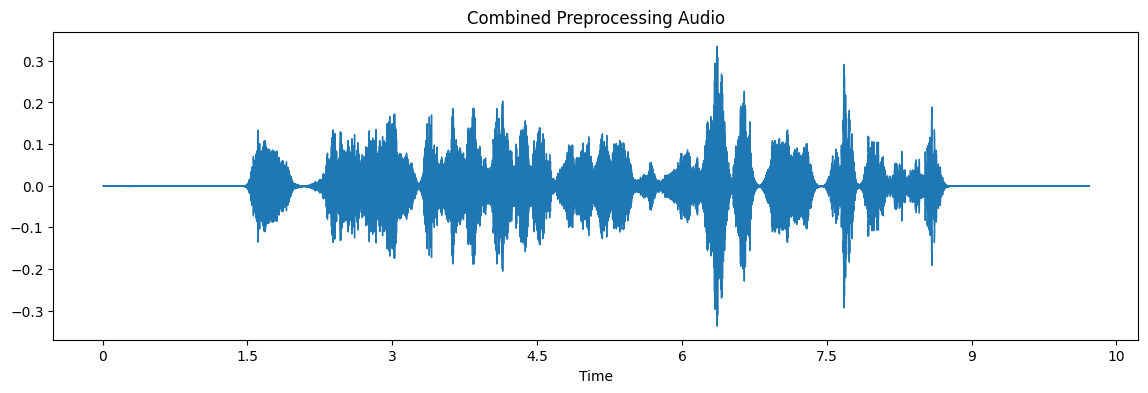

In [ ]:
x=noise(data)
x=stretch(x)
x=shift(x)
x=pitch(x, sample_rate)
plt.figure(figsize=(14,4))
plt.title('Combined Preprocessing Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
plt.figure(figsize=(14,4))
plt.title('Noise Injected Audio')
librosa.display.waveshow(y=dataset_run['train']['audio'][1]['array'], sr=8000)
Audio(dataset_run['train']['audio'][1]['array'], rate=8000)

In [ ]:
len(x)

225281

In [ ]:
len(dataset_run['train']['audio'][1]['array'])

147122

In [ ]:
# match the sampling rate of our audio to that of the Whisper model (16kHz)
from datasets import Audio
dataset_run = dataset_run.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz

    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    path = batch['path']
    data, sample_rate = librosa.load(path)
    x=noise(data)
    x=stretch(x)
    x=shift(x)
    x=pitch(x, sample_rate)
    batch["input_features"] = feature_extractor(x, sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [ ]:
dataset_dict = dataset_run.map(prepare_dataset)

Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("artyomboyko/whisper-small-fine_tuned-ru")
model.generation_config.task = "transcribe"

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [ ]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-multi",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_steps=100,
    gradient_checkpointing=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=256,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["valid"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [ ]:
# pre fine tuned performance
trainer.evaluate(dataset_dict["test"])

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


{'eval_loss': 3.28517484664917,
 'eval_model_preparation_time': 0.0071,
 'eval_wer': 161.8421052631579,
 'eval_runtime': 558.8331,
 'eval_samples_per_second': 0.986,
 'eval_steps_per_second': 0.063}

In [ ]:
# Start training
trainer.train()

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

TrainOutput(global_step=520, training_loss=0.41148514793469354, metrics={'train_runtime': 7369.9872, 'train_samples_per_second': 1.121, 'train_steps_per_second': 0.071, 'total_flos': 2.3837154066432e+18, 'train_loss': 0.41148514793469354, 'epoch': 5.0})

## WHISPER SMALL

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task="transcribe") #['zh', 'ru', 'fr', 'en', 'de']

In [ ]:
input_str = dataset_run["train"][0]["transcription"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 Hallo kurze frage ich wollte nur wissen warum meine Karte nicht funktioniert hat und ich war heute morgen einkaufen und hat nicht mehr funktioniert
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>Hallo kurze frage ich wollte nur wissen warum meine Karte nicht funktioniert hat und ich war heute morgen einkaufen und hat nicht mehr funktioniert<|endoftext|>
Decoded w/out special: Hallo kurze frage ich wollte nur wissen warum meine Karte nicht funktioniert hat und ich war heute morgen einkaufen und hat nicht mehr funktioniert
Are equal:             True


In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="english", task="transcribe")


In [ ]:
dataset_dict = dataset_run.cast_column("audio", Audio(sampling_rate=16000))


In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [ ]:
dataset_dict = dataset_dict.map(prepare_dataset)

Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

model.generation_config.language = "english"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


In [ ]:
metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}



In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-multi",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_steps=100,
    gradient_checkpointing=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=256,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [ ]:
# Start training
trainer.train()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


TrainOutput(global_step=520, training_loss=0.3875296136507621, metrics={'train_runtime': 2045.162, 'train_samples_per_second': 4.039, 'train_steps_per_second': 0.254, 'total_flos': 2.3837154066432e+18, 'train_loss': 0.3875296136507621, 'epoch': 5.0})

In [ ]:
# Start training
trainer.train()

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865

TrainOutput(global_step=520, training_loss=0.012903735127586585, metrics={'train_runtime': 3173.2057, 'train_samples_per_second': 2.603, 'train_steps_per_second': 0.164, 'total_flos': 2.3837154066432e+18, 'train_loss': 0.012903735127586585, 'epoch': 5.0})

## WHISPER MEDIUM

In [ ]:
from transformers import AutoFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-medium")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-medium", language='english', task="transcribe") #['zh', 'ru', 'fr', 'en', 'de']

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [ ]:
input_str = dataset_run["train"][1]["transcription"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 hi I am traveling in Italy right now and I'm just trying to figure out if my
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>hi I am traveling in Italy right now and I'm just trying to figure out if my<|endoftext|>
Decoded w/out special: hi I am traveling in Italy right now and I'm just trying to figure out if my
Are equal:             True


In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-medium", language="english", task="transcribe")

In [ ]:
from datasets import Audio
dataset_dict = dataset_run.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [ ]:
dataset_dict = dataset_dict.map(prepare_dataset)

Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")

model.generation_config.language = "english"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


In [ ]:
metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}



In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-medium-multi",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_steps=100,
    gradient_checkpointing=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=256,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [ ]:
# Start training
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4

TrainOutput(global_step=520, training_loss=0.13076180989065997, metrics={'train_runtime': 11106.5759, 'train_samples_per_second': 0.744, 'train_steps_per_second': 0.047, 'total_flos': 8.4301965361152e+18, 'train_loss': 0.13076180989065997, 'epoch': 5.0})

In [ ]:
tokenizer.push_to_hub("whisper-medium-multi")
processor.push_to_hub("whisper-medium-multi")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anggari/whisper-medium-multi/commit/82f98696b658db80c76454080e872ab75078d8f4', commit_message='Upload processor', commit_description='', oid='82f98696b658db80c76454080e872ab75078d8f4', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [ ]:
pipe = pipeline(model="anggari/whisper-medium-multi", device='cuda')

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

In [ ]:
example = dataset_dict["test"][16]
text = transcribe(example["audio"]["array"])
print(text)

ja schönen guten Tag ich habe gestern meine Kreditkarte in der Stadt verloren und würde sie jetzt nun gerne sperren lassen ich hoffe das funktioniert


In [ ]:
example["transcription"]

'ja schönen guten Tag ich habe gestern meine Kreditkarte in der Stadt verloren und würde sie jetzt ungern sperren lassen ich hoffe das funktioniert'